In [1]:

import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split

from torch.utils.data.dataset import Dataset

import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data = np.load('data/RESISC45_images.npy')
labels = np.load('data/RESISC45_classes.npy')
classes = np.load('data/RESISC45_class_names.npy')

print('Training data shape: ', data.shape)
print('Testing data shape: ', labels.shape)
print('Num Classes', classes.shape)

Training data shape:  (31500, 256, 256, 3)
Testing data shape:  (31500,)
Num Classes (45,)


In [3]:
img_size = 256 # can use this to mofidy data size to fit this model (which only takes 256 images)
n_epochs = 25 #50? depends on max_sampels
print_stride = 1
bs = 16 # 64

z_dim = 1000

learning_rate = 0.0002

In [4]:

#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Resize(img_size),
#     transforms.Normalize([0.5], [0.5])])


xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = 0.25)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = 0.25)

## Training Data
trainset = []
xtrain = torch.tensor(xtrain).permute(0,3,1,2)
print(torch.min(xtrain), torch.max(xtrain))

#xtrain = 2.0*((xtrain / torch.max(xtrain)) - 0.5)
print(torch.min(xtrain), torch.max(xtrain))
#xtrain = (xtrain / torch.max(xtrain)) 
for i in range(xtrain.shape[0]):
    trainset.append((xtrain[i], ytrain[i]))
    
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=False) #MUST keep shuffle false - or else it screws up labels, apparently

## Validation Data
valset = []
xval = torch.tensor(xval).permute(0,3,1,2)

print(torch.min(xval), torch.max(xval))
for i in range(xval.shape[0]):
    trainset.append((xval[i], yval[i]))

val_loader = torch.utils.data.DataLoader(valset, batch_size=bs,
                                          shuffle=False) #MUST keep shuffle false - or else it screws up labels, apparently

## Testing Data
testset = []
xtest = torch.tensor(xtest).permute(0,3,1,2)

print(torch.min(xtest), torch.max(xtest))
for i in range(xtest.shape[0]):
    trainset.append((xtest[i], ytest[i]))

test_loader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                          shuffle=False) #MUST keep shuffle false - or else it screws up labels, apparently



tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


Shape of a batch of images:
torch.Size([16, 3, 256, 256])
Shape of a batch of labels:
torch.Size([16])
tensor(4, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
3
basketball_court


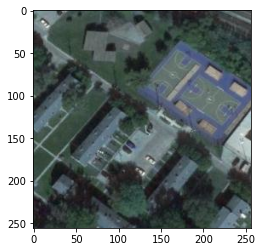

In [5]:
print('Shape of a batch of images:')
print(next(iter(train_loader))[0].shape)
print('Shape of a batch of labels:')
print(next(iter(train_loader))[1].shape)

first_samp = next(iter(train_loader))[0][0] #get first sample in first batch
print(torch.min(first_samp), torch.max(first_samp)) #images naturally (0,255)
plt.imshow(first_samp.permute(1,2,0)/255) #show it

name = next(iter(train_loader))[1][0].data.item()
print(name)
print(classes[name]) 

torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([7875, 3, 256, 256]) (7875,)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(1024)
        
        
        self.conv6 = nn.Conv2d(1024, 2048, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(2048)
        
        self.conv7 = nn.Conv2d(2048, z_dim, 4, 2, 0) # Output: (bs, c_dim, 1, 1)
        

        ## Decoding:
        self.deconv1 = nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0, bias = False) # Not sure how this looks
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias = False)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
        self.deconv4_bn = nn.BatchNorm2d(128)
        
        self.deconv5 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
        self.deconv5_bn = nn.BatchNorm2d(64)
        
        self.deconv6 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False)
        self.deconv6_bn = nn.BatchNorm2d(32)
        
        self.deconv7 = nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def encode(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        #print('enter encode', x.shape)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv6_bn(self.conv6(x)), 0.2)
        #print(x.shape)
        z = self.conv7(x)
        #z = torch.sigmoid(self.conv5(x)) # Variance-space unif~[0,1]
        #print(z.shape)
        return z

    def decode(self, z):
        #print('enter decode', z.shape)
        x = self.deconv1_bn(self.deconv1(z))
        #print(x.shape)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        #print(x.shape)
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        #print(x.shape)
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        #print(x.shape)
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        #print(x.shape)
        x = F.relu(self.deconv6_bn(self.deconv6(x)))
        #print(x.shape)
        x = self.deconv7(x)
        return torch.tanh(x)

    def forward(self, x):
        return self.decode(self.encode(x))


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

def one_hot_embedding(labels):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)

def print_ae_sample():
    with torch.no_grad():
        #next(iter(train_loader))
        X, y = next(iter(train_loader))
        X = torch.FloatTensor(X.float()).to(device)
        y = y.to(device)
        generated = .5*(AE(X).cpu() + 1)
        for i in range(9):
            plt.subplot(330 + 1 + i).set_title(classes[y[i].data.item()])
            # plot raw pixel data
            element = generated[i,:].permute(1,2,0)
            plt.imshow(element)
        plt.show()

In [7]:
AE = Autoencoder()
AE.weight_init()
AE.to(device)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
learning_rate = 0.0003
beta_1 = 0.5
beta_2 = 0.999

AE_optimizer = optim.Adam(AE.parameters(),
                         lr = learning_rate)
                         #betas = (beta_1, beta_2))

Epoch 1 - loss_AE: 0.070


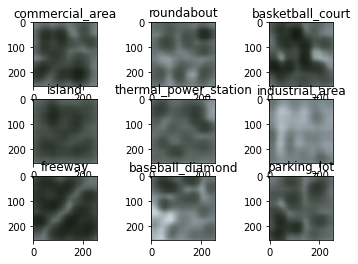

Epoch 2 - loss_AE: 0.056


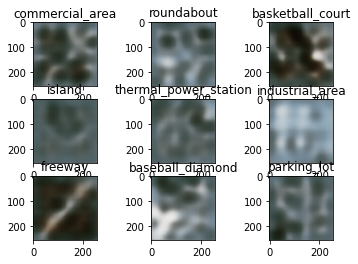

Epoch 3 - loss_AE: 0.051


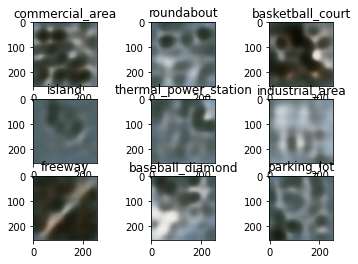

Epoch 4 - loss_AE: 0.048


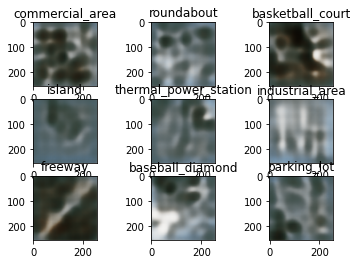

Epoch 5 - loss_AE: 0.047


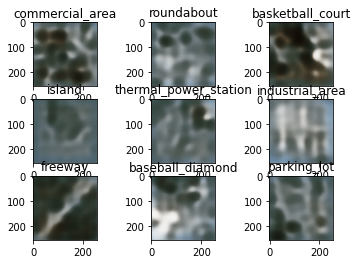

Epoch 6 - loss_AE: 0.045


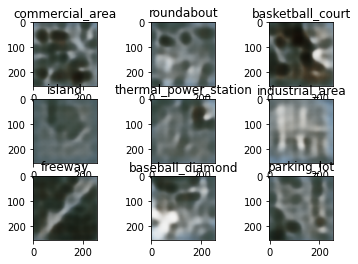

Epoch 7 - loss_AE: 0.044


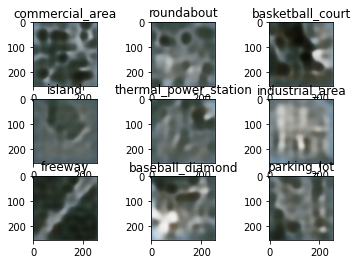

Epoch 8 - loss_AE: 0.043


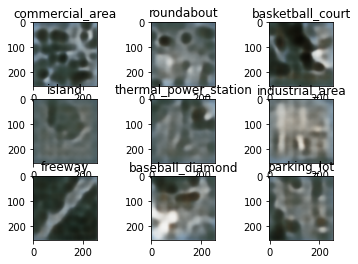

Epoch 9 - loss_AE: 0.042


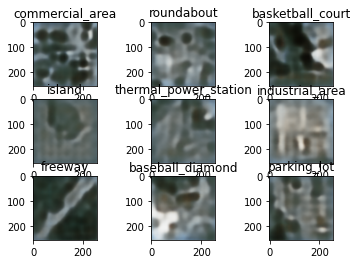

Epoch 10 - loss_AE: 0.041


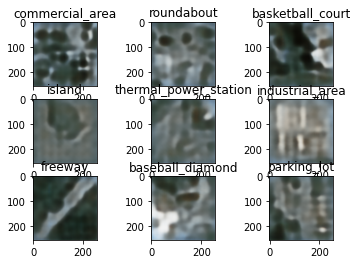

Epoch 11 - loss_AE: 0.041


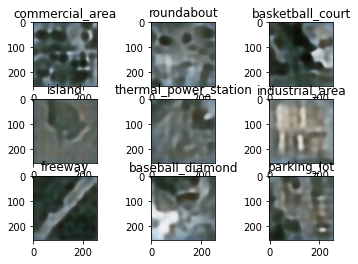

Epoch 12 - loss_AE: 0.040


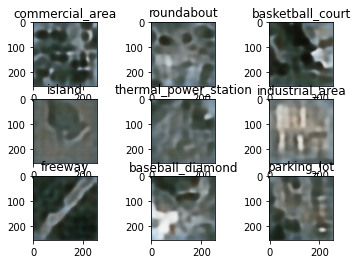

Epoch 13 - loss_AE: 0.039


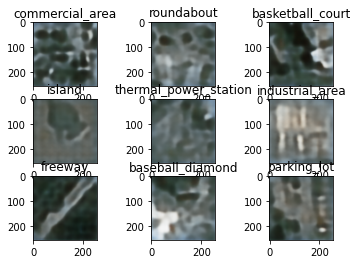

Epoch 14 - loss_AE: 0.039


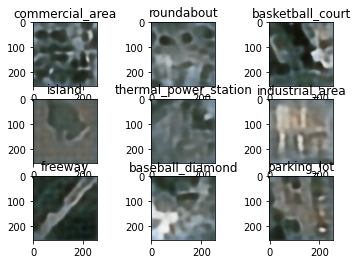

Epoch 15 - loss_AE: 0.038


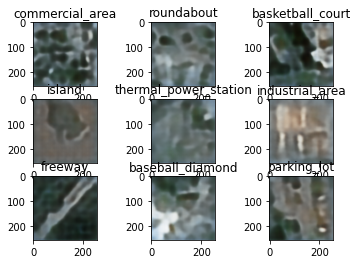

Epoch 16 - loss_AE: 0.037


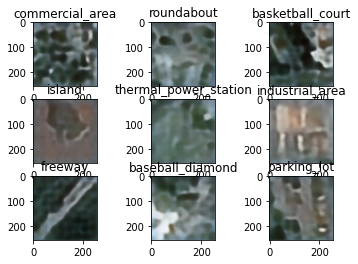

Epoch 17 - loss_AE: 0.037


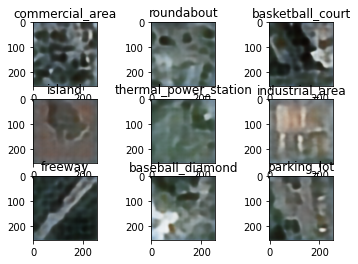

Epoch 18 - loss_AE: 0.037


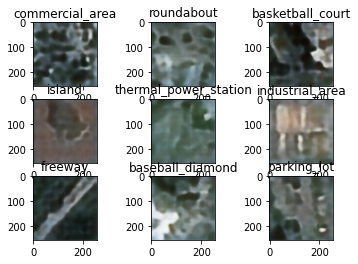

Epoch 19 - loss_AE: 0.036


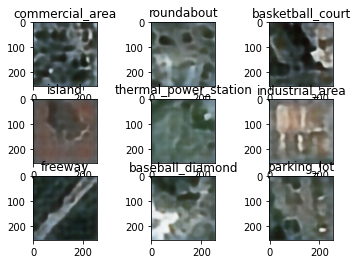

Epoch 20 - loss_AE: 0.036


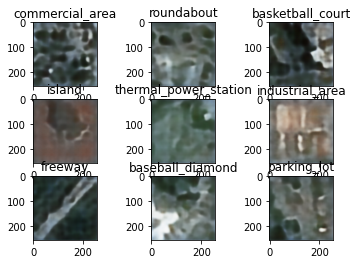

Epoch 21 - loss_AE: 0.035


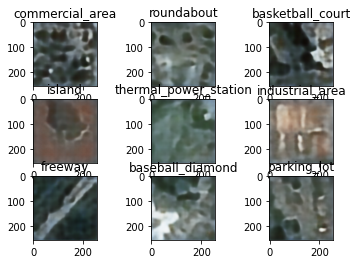

Epoch 22 - loss_AE: 0.035


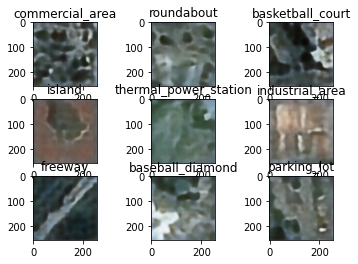

Epoch 23 - loss_AE: 0.035


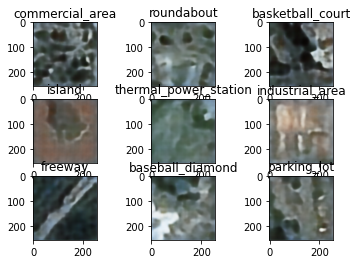

Epoch 24 - loss_AE: 0.035


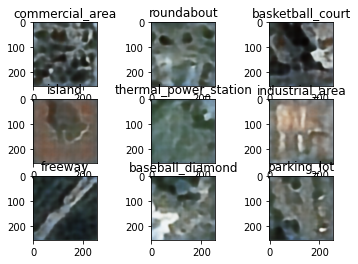

Epoch 25 - loss_AE: 0.034


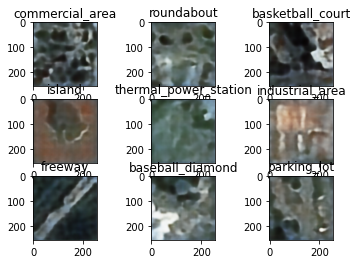

In [8]:
AE_loss_tracker = []
for epoch in range(1, n_epochs+1):

    AE_losses = []

    for X, y in train_loader:
        mini_batch = X.size()[0]
        X = X.to(device).float()
        X = 2.0*(X/255 - 0.5)
        y = y.to(device)

        ## Generator Training
        for param in AE.parameters():
            param.grad = None

        Xhat = AE(X)
        
        AE_loss = mse_loss(Xhat, X)
        
        model_loss = AE_loss

        model_loss.backward()
        AE_optimizer.step()

        AE_losses.append(AE_loss.data.item())
        

    if epoch % print_stride == 0:
        print('Epoch {} - loss_AE: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(AE_losses))))

        AE_loss_tracker.append(torch.mean(torch.FloatTensor(AE_losses)))
        print_ae_sample()

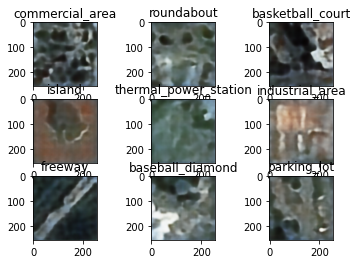

In [15]:
print_ae_sample()

In [16]:
plt.plot(ae_loss_tracker, label = 'Training Reconstruction Loss')
plt.xlabel('Training Epochs')
plt.ylabel('MSE Loss')
plt.show()

NameError: name 'ae_loss_tracker' is not defined